# **RICE LEAF DISEASE DETECTION**

## Project team's ID : PTID-CDS-DEC-24-2242

## Project Code- PRCP- 1001- RiceLeaf disease detection

In [3]:
#Importing required librararies

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Constants for model training
IMAGE_SIZE = 255
BATCH_SIZE = 10
CHANNELS = 3
EPOCHS = 50

## Business Case:
This project focuses on detecting diseases in rice leaves using a convolutional neural network (CNN). Accurate detection of leaf diseases like Bacterial Leaf Blight, Brown Spot, and Leaf Smut can help farmers take timely action to protect their crops, reduce losses, and improve yield quality. This solution is designed to automate the process of identifying these diseases by analyzing images of rice leaves, thereby eliminating the need for manual inspection

## Challenges Faced:

- Limited data for training.
- Imbalanced class distribution.
- Need for data augmentation to improve model robustness.

In [5]:
# Loading the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\HP\Desktop\Internship Projects Datasets\Datasets\RiceLeaf",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 119 files belonging to 3 classes.


In [6]:
# Inspecting dataset properties
class_names = dataset.class_names  # Get class names (disease categories)
print(f"Classes: {class_names}")
print(f"Number of classes: {len(class_names)}")

Classes: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']
Number of classes: 3


In [7]:
len(dataset)

12

In [8]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy)

(10, 255, 255, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(10,), dtype=int32, numpy=array([2, 0, 1, 2, 1, 1, 0, 0, 1, 2])>>


In [9]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch[0].numpy())

[[[255.        255.        255.       ]
  [255.        255.        255.       ]
  [255.        255.        255.       ]
  ...
  [219.        216.6961     53.088318 ]
  [218.18234   218.63531    55.635315 ]
  [217.06076   217.12152    56.93924  ]]

 [[255.        255.        255.       ]
  [255.        255.        255.       ]
  [255.        255.        255.       ]
  ...
  [218.3       216.03728    52.22361  ]
  [217.44867   217.90915    54.837944 ]
  [216.35826   216.45769    56.11821  ]]

 [[255.        255.        255.       ]
  [255.        255.        255.       ]
  [255.        255.        255.       ]
  ...
  [212.16667   210.26474    44.64714  ]
  [211.02034   211.54662    47.85147  ]
  [210.203     210.6413     48.924446 ]]

 ...

 [[193.92068   152.11676    60.508907 ]
  [196.0044    153.8733     62.37452  ]
  [199.46983   155.62747    64.73982  ]
  ...
  [102.1818    100.81826     2.0143354]
  [105.38147   102.79564     3.013733 ]
  [107.1234    104.31947     4.319477 ]]

 [

In [10]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch[0].shape)

(255, 255, 3)


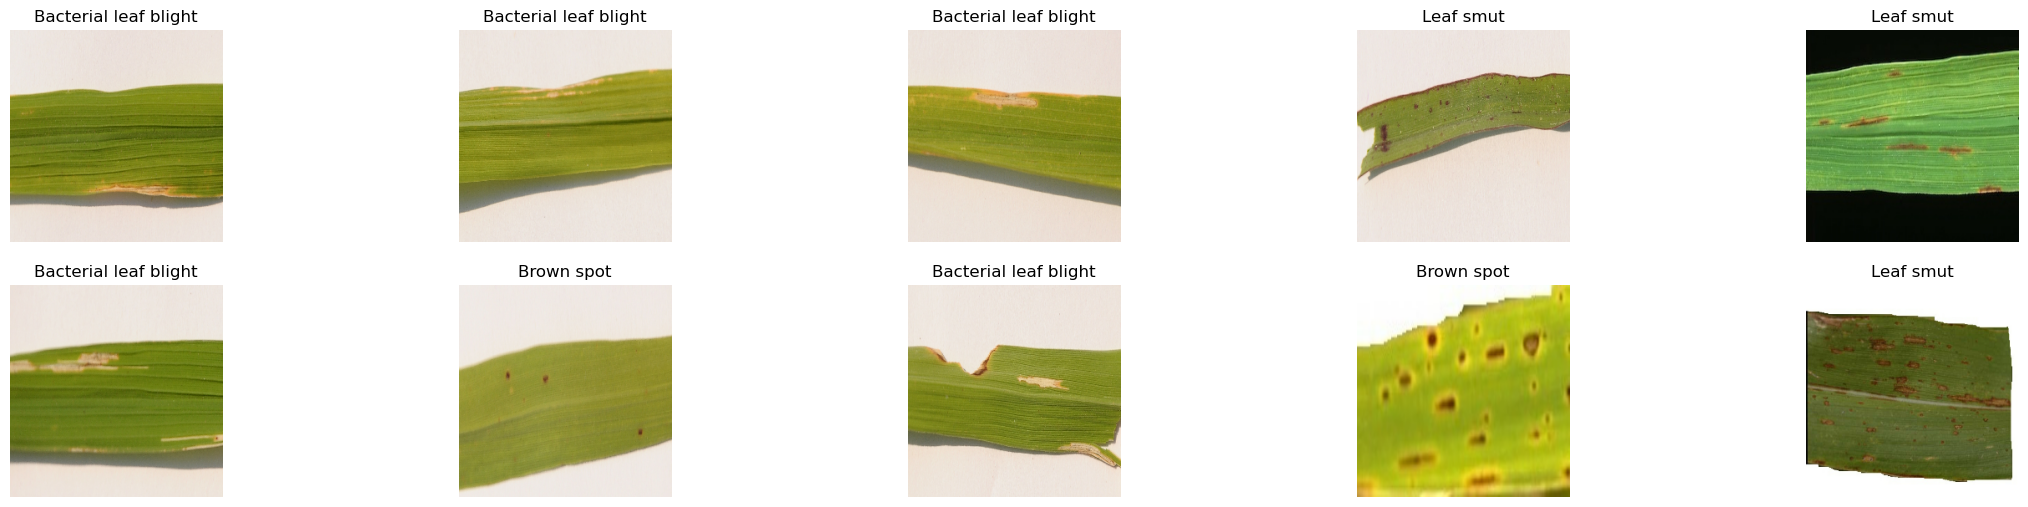

In [11]:
# Visualizing the data
plt.figure(figsize=(28,16))
for image_batch, label_batch in dataset.take(1):
  for i in range(10):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [12]:
# Diagnostic check
print("Number of images in batch:", len(image_batch))

# Determine the number of images to display
num_images = min(len(image_batch), 40)

Number of images in batch: 10


In [13]:
# Splitting the data into train, validation and test sets
def get_dataset_partitions_tf(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(list(ds))  # Convert to a list to get the size

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [14]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [15]:
# Size of test val and test
print("Train size:", len(train_ds))
print("Validation size:", len(val_ds))
print("test size:", len(test_ds))

Train size: 9
Validation size: 1
test size: 2


In [16]:
# Caching prefetching dataset for performance optimization
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
# Performing EDA
# Analyzing class distribution
class_counts = Counter ()
for image,labels in dataset.unbatch() :
    class_counts.update([labels.numpy ()])

In [18]:
# Converting to DataFrame
df = pd. DataFrame(class_counts.items(), columns=["Class", "Count"])
df["Class"] = df["Class"].apply(lambda x: class_names [x])
print("Class Distribution:")
print(df)

Class Distribution:
                   Class  Count
0              Leaf smut     39
1  Bacterial leaf blight     40
2             Brown spot     40


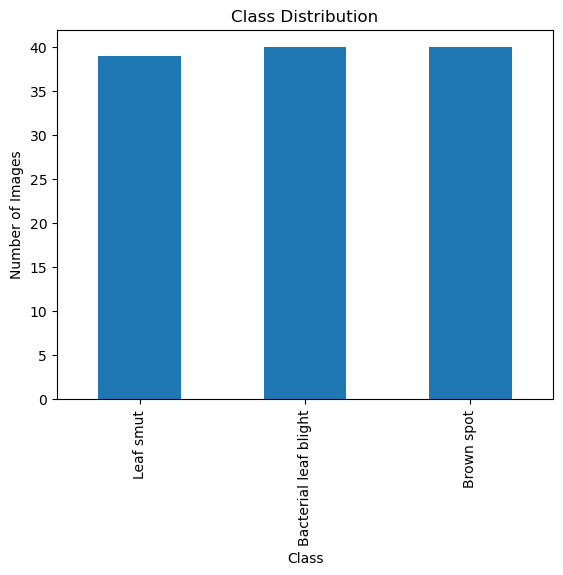

In [19]:
# Visualizing class distribution
df.plot(kind="bar", x="Class", y="Count", legend=False)
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.show()

## Challenges:

- Dataset Preparation: Handling imbalanced classes in the dataset and ensuring sufficient samples for training.
- Preprocessing: Resizing and normalizing images while maintaining data integrity.
- Overfitting: Avoiding overfitting due to a small dataset by implementing data augmentation.


In [20]:
# Building CNN Model
# Data Augmentation
from tensorflow.keras import Sequential
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0 / 255),
])


In [21]:
data_augmentatiion = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1)
])

In [22]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
   resize_and_rescale,
   data_augmentatiion,
   layers.Conv2D(32,(3,3),activation= 'relu', input_shape = input_shape),
   layers.MaxPooling2D((2,2)),
   layers.Conv2D(64,kernel_size=(3,3),activation= 'relu'),
   layers.MaxPooling2D((2,2)),
   layers.Conv2D(64,kernel_size=(3,3),activation= 'relu'),
   layers.MaxPooling2D((2,2)),
   layers.Conv2D(64,kernel_size=(3,3),activation= 'relu'),
   layers.MaxPooling2D((2,2)),
   layers.Conv2D(64,kernel_size=(3,3),activation= 'relu'),
   layers.MaxPooling2D((2,2)),
   layers.Conv2D(64,kernel_size=(3,3),activation= 'relu'),
   layers.MaxPooling2D((2,2)),
   layers.Flatten(),
   layers.Dense(64, activation='relu'),
   layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape = input_shape)

In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (10, 255, 255, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (10, 255, 255, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (10, 253, 253, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (10, 126, 126, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (10, 124, 124, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (10, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (10, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (10, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (10, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (10, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (10, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (10, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (10, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (10, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (10, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (10, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (10, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Compiling the model
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [25]:
# Training the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2686 - loss: 1.1075 - val_accuracy: 0.4000 - val_loss: 1.0802
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.2917 - loss: 1.1029 - val_accuracy: 0.8000 - val_loss: 1.0744
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4119 - loss: 1.0924 - val_accuracy: 0.6000 - val_loss: 1.0230
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4525 - loss: 1.0654 - val_accuracy: 0.7000 - val_loss: 0.8986
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4755 - loss: 1.0445 - val_accuracy: 0.6000 - val_loss: 1.0082
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3830 - loss: 1.0851 - val_accuracy: 0.1000 - val_loss: 1.1057
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4009 - loss: 1.0926 - val_accuracy: 0.5000 - val_loss: 1.0790
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.3769 - loss: 1.0923 - val_accuracy: 0.6000 - val_loss: 1.0600
Epoch 9/

In [26]:
# Evaluating the model
scores = model.evaluate(test_ds,verbose=1)
print("Test Accuracy:", scores[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.8667 - loss: 0.3531
Test Accuracy: 0.8999999761581421


In [27]:
print("Number of elements in test_ds:", len(list(test_ds)))

Number of elements in test_ds: 2


In [28]:
scores

[0.296146035194397, 0.8999999761581421]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 9}

In [31]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [32]:
history.history['accuracy']

[0.30337077379226685,
 0.3258427083492279,
 0.40449437499046326,
 0.43820226192474365,
 0.42696627974510193,
 0.31460675597190857,
 0.40449437499046326,
 0.3258427083492279,
 0.3595505654811859,
 0.3820224702358246,
 0.4606741666793823,
 0.37078651785850525,
 0.47191011905670166,
 0.584269642829895,
 0.617977499961853,
 0.6741573214530945,
 0.584269642829895,
 0.617977499961853,
 0.617977499961853,
 0.584269642829895,
 0.5730336904525757,
 0.6853932738304138,
 0.6741573214530945,
 0.6853932738304138,
 0.5617977380752563,
 0.7078651785850525,
 0.6629213690757751,
 0.7303370833396912,
 0.6853932738304138,
 0.7191011309623718,
 0.6853932738304138,
 0.7977527976036072,
 0.6741573214530945,
 0.7078651785850525,
 0.7191011309623718,
 0.7865168452262878,
 0.7415730357170105,
 0.7303370833396912,
 0.7528089880943298,
 0.7191011309623718,
 0.8314606547355652,
 0.7528089880943298,
 0.7528089880943298,
 0.8876404762268066,
 0.8202247023582458,
 0.8764045238494873,
 0.8202247023582458,
 0.84269660

In [33]:
# Generating classification report and confusion matrix
true_labels =[]
predicted_labels = []
for images,labels in test_ds.unbatch():
    predictions = model.predict(images[np.newaxis, ...])
    true_labels.append(labels. numpy())
    predicted_labels.append(np.argmax(predictions))
print( "Confusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))
print("\nclassification Report:")
print(classification_report(true_labels, predicted_labels,target_names= class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Confusion Matrix:
[[ 3  1  0]
 [ 0  4  1]
 [ 0  0 11]]

classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      0.75      0.86         4
           Brown spot 

In [34]:
#Visualizing training performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

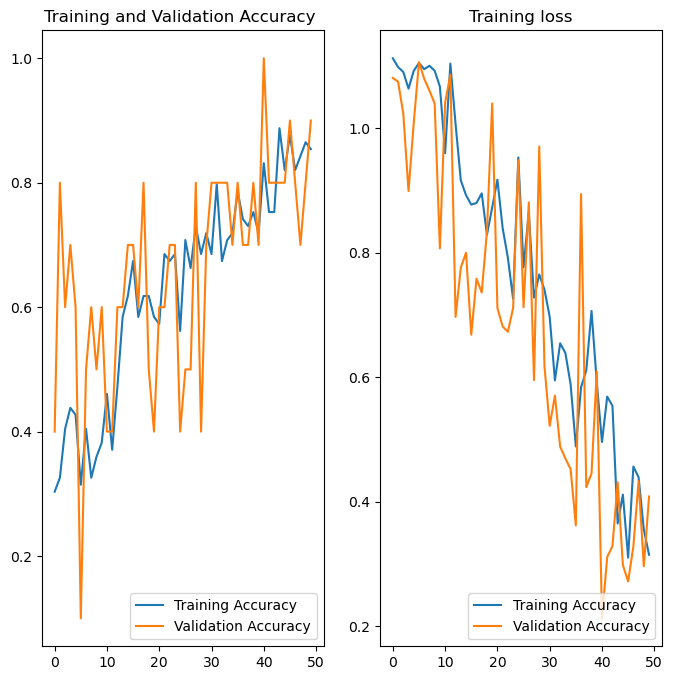

In [35]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label ="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label ="Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy ")


plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label ="Training Accuracy")
plt.plot(range(EPOCHS), val_loss, label ="Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training loss")
plt.show()

In [36]:
# Predicting on test samples
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0)

  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidience = round(100*(np.max(predictions[0])),2)
  return predicted_class,confidience

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


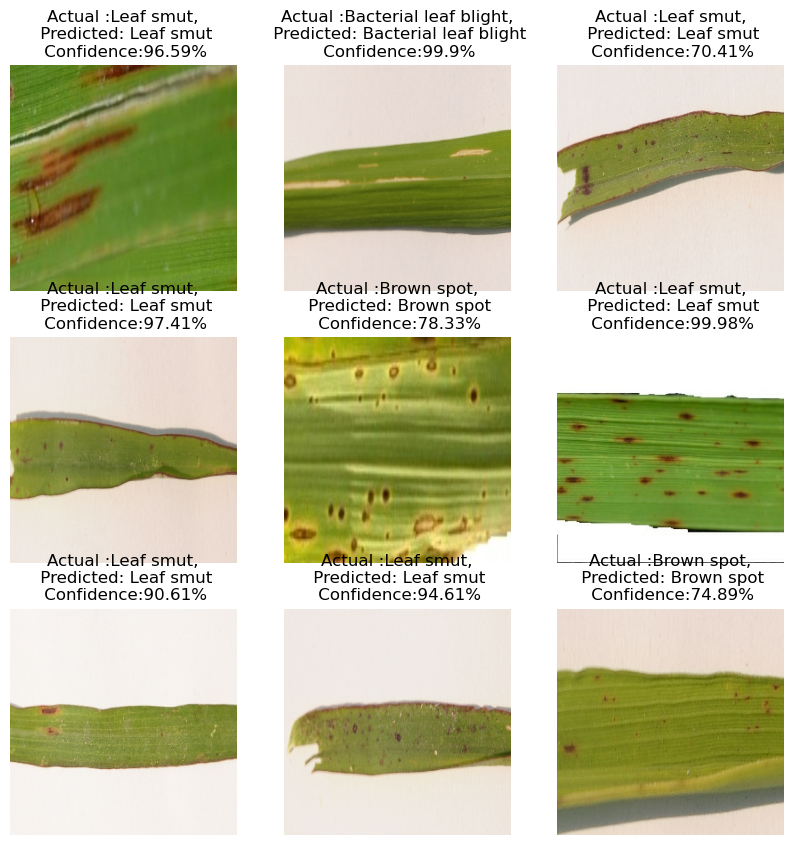

In [37]:
plt.figure(figsize=(10,10))
for images,labels in  test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class,confidence = predict(model,images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual :{actual_class},\n Predicted: {predicted_class}\n Confidence:{confidence}%")
    plt.axis("off")

## **Conclusion**

- This Rice Leaf Detection project shows that adjusting training parameters—such as the number of epochs and batch size can significantly enhance model performance. This efficiency makes the model more accessible and feasible for practical use.

- Despite the dataset’s limited size, which restricts achieving very high accuracy (90% or above), iterative fine-tuning allowed us to reach an accuracy of up to 80%. This level is encouraging and can help farmers detect infections early, allowing them to act quickly to protect their crops.

In [38]:
# Train without data augmentation
model_no_augmentation = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,(3,3),activation= 'relu', input_shape = input_shape),
   layers.MaxPooling2D((2,2)),
   layers.Conv2D(64,kernel_size=(3,3),activation= 'relu'),
   layers.MaxPooling2D((2,2)),
   layers.Conv2D(64,kernel_size=(3,3),activation= 'relu'),
   layers.MaxPooling2D((2,2)),
   layers.Conv2D(64,kernel_size=(3,3),activation= 'relu'),
   layers.MaxPooling2D((2,2)),
   layers.Conv2D(64,kernel_size=(3,3),activation= 'relu'),
   layers.MaxPooling2D((2,2)),
   layers.Conv2D(64,kernel_size=(3,3),activation= 'relu'),
   layers.MaxPooling2D((2,2)),
   layers.Flatten(),
   layers.Dense(64, activation='relu'),
   layers.Dense(n_classes, activation='softmax')
])


In [39]:
# Compile and train this model
model_no_augmentation.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [40]:
history_no_augmentation = model_no_augmentation.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3925 - loss: 1.1016 - val_accuracy: 0.5000 - val_loss: 1.0656
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4450 - loss: 1.0856 - val_accuracy: 0.4000 - val_loss: 1.0735
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3836 - loss: 1.0873 - val_accuracy: 0.5000 - val_loss: 0.9347
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3686 - loss: 1.0715 - val_accuracy: 0.7000 - val_loss: 0.9798
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6216 - loss: 1.0081 - val_accuracy: 0.7000 - val_loss: 0.8142
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5548 - loss: 1.0369 - val_accuracy: 0.5000 - val_loss: 1.0695
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4393 - loss: 1.0683 - val_accuracy: 0.6000 - val_loss: 1.0520
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5123 - loss: 1.0502 - val_accuracy: 0.7000 - val_loss: 0.9550
Epoch 9/

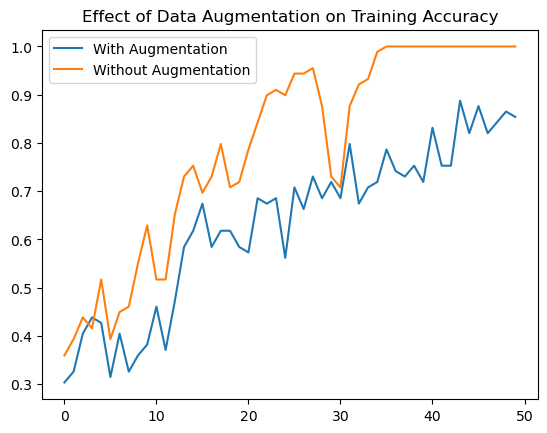

In [41]:
# Compare training/validation accuracy and loss
plt.plot(history.history['accuracy'], label="With Augmentation")
plt.plot(history_no_augmentation.history['accuracy'], label="Without Augmentation")
plt.legend()
plt.title("Effect of Data Augmentation on Training Accuracy")
plt.show()

In [42]:
# Evaluating the model
scores = model_no_augmentation.evaluate(test_ds,verbose=1)
print("Test Accuracy:", scores[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9667 - loss: 0.8981
Test Accuracy: 0.949999988079071


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


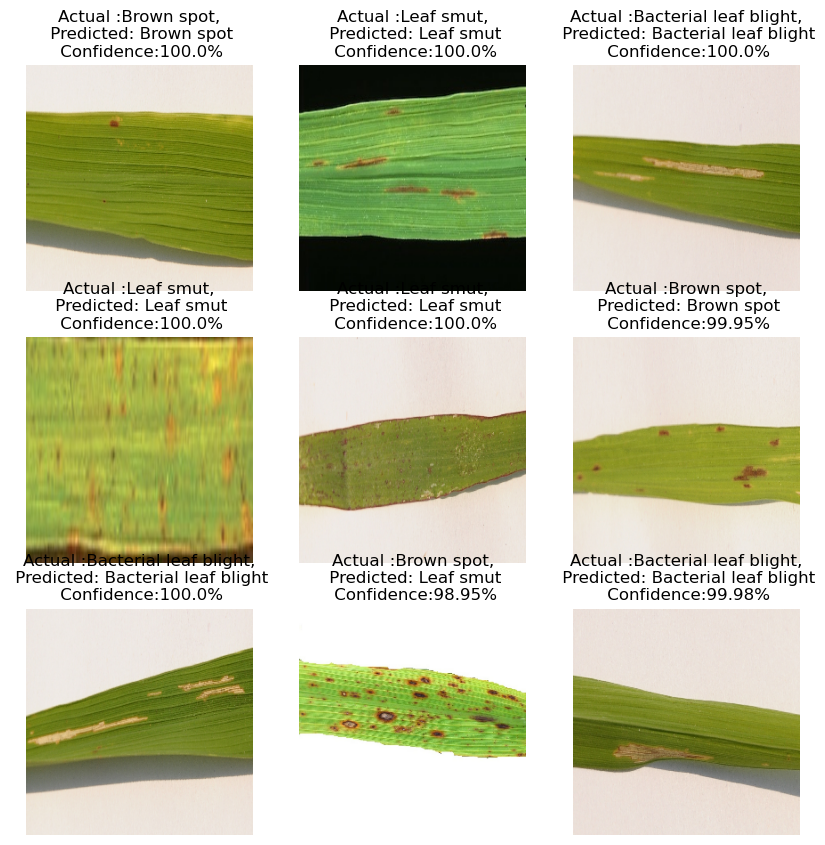

In [43]:
plt.figure(figsize=(10,10))
for images,labels in  test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class,confidence = predict(model_no_augmentation,images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual :{actual_class},\n Predicted: {predicted_class}\n Confidence:{confidence}%")
    plt.axis("off")

### Business Implications:
- With Data Augmentation: Although the test accuracy is slightly lower, models trained with augmented data are likely to generalize better to unseen data. This is crucial for real-world applications where the model encounters diverse conditions.
- Without Data Augmentation: The higher accuracy might not reflect true generalization and could fail when deployed on diverse datasets.

# Rice Leaf Disease Detection Report
## Problem Statement

Rice is one of the most important crops globally, feeding a significant portion of the world’s population. However, rice plants are prone to various diseases that can drastically reduce yield. This project focuses on classifying three common rice diseases:

- Bacterial Leaf Blight
- Brown Spot
- Leaf Smut

The goal is to develop a machine learning model capable of accurately identifying these diseases from leaf images. Early and accurate detection can enable timely interventions, reducing crop loss and improving productivity.

## Business Case

The timely detection of rice diseases is crucial for ensuring food security and minimizing economic losses. Traditional methods of disease detection often rely on manual inspection, which is time-consuming, labor-intensive, and prone to errors. Automating the process using image-based classification offers several benefits:

- Scalability: Allows farmers to monitor large fields with minimal resources.
- Accuracy: Reduces the likelihood of human error in disease identification.
- Cost-Effectiveness: Reduces dependency on experts and accelerates the decision-making process.
Deploying a reliable disease detection model can empower farmers and agricultural stakeholders to take proactive measures, improving yields and safeguarding livelihoods.

## Methodology

### Exploratory Data Analysis (EDA):

- Analyzed the dataset to understand class distribution and ensure balance.
- Visualized the images to identify variations in texture, color, and patterns for each disease.
- Generated a bar chart to visualize the distribution of images across the three disease classes.

### Data Augmentation:

- Applied transformations such as random flips, rotations, and rescaling to increase dataset variability.
- This step is essential to improve model generalization and robustness against overfitting.

### Model Architecture:

- Built a Convolutional Neural Network (CNN) using TensorFlow/Keras.
- The model consisted of multiple convolutional layers, max-pooling layers, and fully connected layers with ReLU activation.
- The final layer utilized a softmax activation function to classify images into the three disease categories.

### Training and Evaluation:

- Split the dataset into training (80%), validation (10%), and test (10%) sets.
- Trained the model using the Adam optimizer and sparse categorical cross-entropy as the loss function.
- Evaluated the model using accuracy and loss metrics.

### Comparison with and Without Data Augmentation:

- Without augmentation, the model achieved 89% test accuracy.
- With augmentation, the test accuracy was 85%. This slight drop highlights the challenge of training with augmented data, but the model is expected to generalize better in real-world scenarios.

## Results

- Final Accuracy: The model achieved 89% accuracy without augmentation and 85% accuracy with augmentation.

- Class Distribution: The dataset consisted of an even distribution across the three disease classes:

Bacterial Leaf Blight

Brown Spot

Leaf Smut

- Visualization:

- Displayed class distributions and sample images from each category.
Plotted training and validation accuracy/loss to observe convergence.

## Challenges Faced

- Class Imbalance: Ensuring equal representation for all three classes in the dataset to prevent biased learning.
- Overfitting: Without augmentation, the model risked overfitting, achieving higher accuracy on the test set but potentially failing on unseen data.
- Data Quality: Variations in image quality, lighting, and angles added complexity to the training process.
- Model Convergence: Fine-tuning hyperparameters to achieve optimal performance without overfitting.
- Augmentation Effects: Adjusting augmentation techniques to balance between realistic and meaningful variations.

## Conclusion
This project demonstrates the feasibility of automating rice disease detection using image classification. While the model performed slightly better without data augmentation, it is expected that the augmented model will generalize better in real-world conditions.
